### FLORIS CALIBRATION

In [89]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable


import numpy as np 
import pathlib
import pandas as pd
import scipy as sp
import pickle
import sys
import os

import floris.layout_visualization as layoutviz
from floris import (
    FlorisModel,
    TimeSeries,
    WindRose,
    WindTIRose,
)
from floris.flow_visualization import visualize_cut_plane

library_path = '../'
if library_path not in sys.path:
    sys.path.append(library_path)
import calibrate_floris as cf
import floris
print(f"The source file for the floris library is located at: {floris.__file__}")

The source file for the floris library is located at: /projects/wind_uq/gyalla/src/python/TCF_03_24_2025/lib/python3.12/site-packages/floris/__init__.py


### SETUP FLORIS CASES 

In [ ]:
#Define list of cases 

cases = [
    "MedWS_LowTI_Pulse_A4_St0p3_6D_45",
    "MedWS_LowTI_Pulse_A2_St0p3_6D_45",
]

#Specify setup files to be generated for each case
setup_files = {}
setup_files[cases[0]] = 'MedWS_LowTI_Pulse_A4_St0p3_6D_45_emgauss.yaml'
setup_files[cases[1]] = 'MedWS_LowTI_Pulse_A2_St0p3_6D_45_emgauss.yaml'

#Specify original version of floris yaml that will be modified
input_setup_files = {}
input_setup_files[cases[0]] = 'MedWS_LowTI_Baseline_6D_45_emgauss.yaml'
input_setup_files[cases[1]] = 'MedWS_LowTI_Baseline_6D_45_emgauss.yaml'

wind_speed_factor = 0.9728408350292002
wind_speed = 9.01
setup_params = {
    'flow_field.wind_speeds': [wind_speed * wind_speed_factor,],
    'farm.turbine_type': ['iea_15MW_calibrate'],
    'farm.turbine_library_path': './turbine_library/',
    'wake.enable_active_wake_mixing': True,
}

layouts  = {}

In [91]:
os.system('cp ./turbine_library/iea_15MW_orig.yaml ./turbine_library/iea_15MW_calibrate.yaml')

0

In [ ]:
awc_arrays = {}
awc_arrays[cases[0]] = ['helix','helix','helix','baseline','baseline','baseline','baseline','baseline','baseline']
awc_arrays[cases[1]] = ['helix','helix','helix','baseline','baseline','baseline','baseline','baseline','baseline']

awc_amplitudes = {}
awc_amplitudes[cases[0]] = [4,4,4,4,4,4,4,4,4]
awc_amplitudes[cases[1]] = [2,2,2,2,2,2,2,2,2]

baseline_array = ['baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline','baseline']

In [93]:

floris_models = {}

for case in cases:
    cf.setup_floris_yaml(input_setup_files[case],setup_params,output_file=setup_files[case])
    floris_model = FlorisModel(setup_files[case])

    floris_model.set_operation_model(["awc"] * 9)
    floris_model.set(
    awc_modes=np.array([awc_arrays[case]]),
    awc_amplitudes=np.array([awc_amplitudes[case]])
    )

    floris_models[case] = floris_model
    print("Setup floris model for " + case + " with configuration file: ", floris_model.configuration)


Setup floris model for MedWS_LowTI_Pulse_A4_St0p3_6D_45 with configuration file:  MedWS_LowTI_Pulse_A4_St0p3_6D_45_emgauss.yaml
Setup floris model for MedWS_LowTI_Pulse_A2_St0p3_6D_45 with configuration file:  MedWS_LowTI_Pulse_A2_St0p3_6D_45_emgauss.yaml


In [94]:
for case in cases:
    floris_model = floris_models[case]
    floris_model.set_operation_model('awc')
    floris_model.set(
    awc_modes=np.array([baseline_array]),
    awc_amplitudes=np.array([awc_amplitudes[case]])
    )
    floris_model.run()
    bs_turbine_powers = floris_model.get_turbine_powers()/1000
    print("Baseline: ",bs_turbine_powers)

    floris_model = floris_models[case]
    floris_model.set_operation_model('awc')
    floris_model.set(
    awc_modes=np.array([awc_arrays[case]]),
    awc_amplitudes=np.array([awc_amplitudes[case]])
    )
    floris_model.run()
    awc_turbine_powers = floris_model.get_turbine_powers()/1000
    print("AWC: ",awc_turbine_powers)
    print("Initial Delta: ",awc_turbine_powers-bs_turbine_powers)
    print()



Baseline:  [[8429.11915394 8429.11915394 8429.11915394 3414.07310729 3414.07310729
  3414.07310729 4461.90886772 4461.90886772 4461.90886772]]
AWC:  [[7894.41523758 7894.41523758 7894.41523758 5711.48095905 5711.48095905
  5711.48095905 4656.04885765 4656.04885763 4656.04885765]]
Initial Delta:  [[-534.70391636 -534.70391636 -534.70391636 2297.40785175 2297.40785175
  2297.40785175  194.13998993  194.13998991  194.13998993]]

Baseline:  [[8429.11915394 8429.11915394 8429.11915394 3414.07310729 3414.07310729
  3414.07310729 4461.90886772 4461.90886772 4461.90886772]]
AWC:  [[8276.52071078 8276.52071078 8276.52071078 4635.33448269 4635.33448269
  4635.33448269 4613.28579238 4613.28579238 4613.28579238]]
Initial Delta:  [[-152.59844316 -152.59844316 -152.59844316 1221.2613754  1221.2613754
  1221.2613754   151.37692466  151.37692466  151.37692466]]



### CALIBRATION

In [ ]:
#initial values for calibration parameters
calibration_params = {
        'wake.wake_velocity_parameters.empirical_gauss.awc_wake_exp': 1.2,
        'wake.wake_velocity_parameters.empirical_gauss.awc_wake_denominator': 400
    }

#bounds for each parameter
calibration_bounds = {
        'wake.wake_velocity_parameters.empirical_gauss.awc_wake_exp': (0.1,None),
        'wake.wake_velocity_parameters.empirical_gauss.awc_wake_denominator': (100,None)
}

#try perturbing these
turbine_calibration_params = {}
turbine_calibration_params['iea_15MW_calibrate'] = {
        'power_thrust_table.helix_a': 0,
        'power_thrust_table.helix_power_b': -7.54447476e-04,
        'power_thrust_table.helix_power_c': 2.42392777,
        'power_thrust_table.helix_thrust_b': 0.00884314,
        'power_thrust_table.helix_thrust_c': 1.8355158,
}
#turbine_calibration_params = None
turbine_calibration_bounds = {}
turbine_calibration_bounds['iea_15MW_calibrate'] = {
        'power_thrust_table.helix_a': (0,0),
        'power_thrust_table.helix_power_b': (-1.0e-3,-1e-5),
        'power_thrust_table.helix_power_c': (1,10),
        'power_thrust_table.helix_thrust_b': (0.0001,0.01),
        'power_thrust_table.helix_thrust_c': (1,10),
}
#turbine_calibration_bounds = None

target_data = {}
target_data[cases[0]] = ('turbine_power','./LES_data/MedWS_LowTI_Pulse_A4_St0p3_Minus_Baseline_6D_45.csv')
target_data[cases[1]] = ('turbine_power','./LES_data/MedWS_LowTI_Pulse_A2_St0p3_Minus_Baseline_6D_45.csv')


In [96]:
solver = cf.FLORIS_Optimizer(floris_models,calibration_params,target_data,calibration_bounds,turbine_calibration_params,turbine_calibration_bounds)

Turbine file:  /gpfs/gyalla/Advanced_Controls/Floris/FLORIS_Calibration/Example/turbine_library/iea_15MW_calibrate.yaml


In [97]:

MLE=solver.optimize(maxiter = 1000,globalSolve=False,savecsv='awc_cost_function.csv')
print(MLE)

cost function:  2640129.686509169 , iteration:  1
cost function:  2640129.771006359 , iteration:  2
cost function:  2640129.68632838 , iteration:  3
cost function:  2640129.7510062046 , iteration:  4
cost function:  2640129.6864424828 , iteration:  5
cost function:  2640128.590019021 , iteration:  6
cost function:  2640129.6743226456 , iteration:  7
cost function:  2621038.7310994198 , iteration:  8
cost function:  2621038.81523953 , iteration:  9
cost function:  2621038.7309198524 , iteration:  10
cost function:  2621038.7948197997 , iteration:  11
cost function:  2621038.731033537 , iteration:  12
cost function:  2621037.6369509944 , iteration:  13
cost function:  2621038.718938225 , iteration:  14
cost function:  2545924.334323963 , iteration:  15
cost function:  2545924.417042967 , iteration:  16
cost function:  2545924.334149222 , iteration:  17
cost function:  2545924.394923712 , iteration:  18
cost function:  2545924.3342613108 , iteration:  19
cost function:  2545923.2496461994

In [102]:
print(MLE)

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 173631.20076664767
        x: [ 1.705e+00  1.824e+03  0.000e+00 -3.492e-04  3.018e+00
             2.895e-03  2.464e+00]
      nit: 33
      jac: [-4.231e+02  4.610e+00        nan -5.150e+03  5.676e+02
            -1.240e+02 -1.074e+04]
     nfev: 357
     njev: 51
 hess_inv: None


                0
0    2.640130e+06
1    2.640130e+06
2    2.640130e+06
3    2.640130e+06
4    2.640130e+06
..            ...
352  1.736312e+05
353  1.736312e+05
354  1.736312e+05
355  1.736312e+05
356  1.736312e+05

[357 rows x 1 columns]


<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_133342/2725184708.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mathcal{J} \; / \; \mathcal{J}_0$',fontsize=fsize)


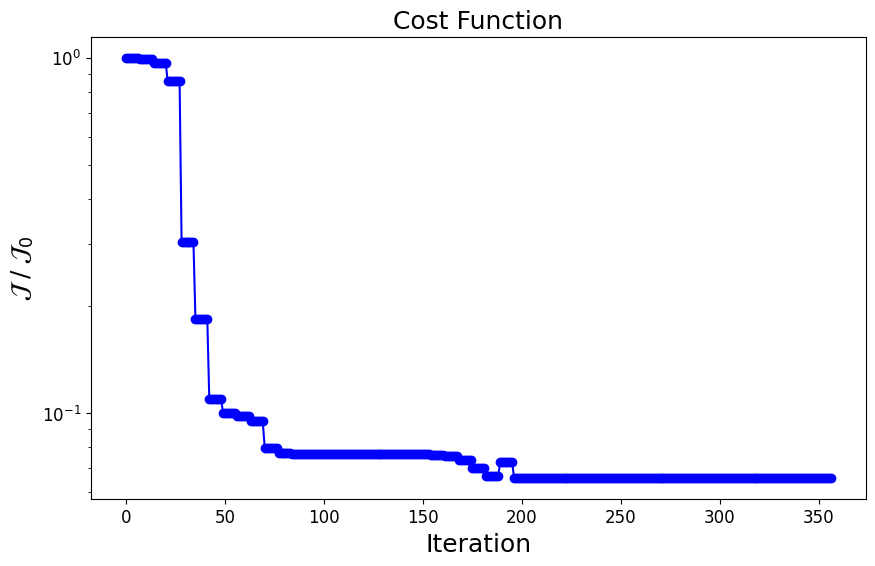

In [103]:
# Function to load CSV and plot values
def load_and_plot_csv(filename):
    fsize =18
    # Load the CSV file into a DataFrame
    data = pd.read_csv(filename, header=None)  # Use header=None since there are no headers
    print(data)

    # Extract the values from the DataFrame
    values = data.values  # Get the first row as a NumPy array
    values = values / values[0]

    # Create an index array
    indices = range(len(values))

    # Plot the values as a function of index
    plt.figure(figsize=(10, 6))
    plt.semilogy(indices, values, marker='o', linestyle='-', color='b')
    plt.title('Cost Function',fontsize=fsize)
    plt.xlabel('Iteration',fontsize=fsize)
    plt.ylabel('$\mathcal{J} \; / \; \mathcal{J}_0$',fontsize=fsize)
    #plt.ylim(0,2.0)
    #plt.xticks(indices)  # Set x-ticks to show all indices
    plt.tick_params(axis='x', labelsize=12)  # Change x tick label size
    plt.tick_params(axis='y', labelsize=12)  # Change y tick label size
    plt.show()

# Specify the filename
filename = 'awc_cost_function.csv'
# Call the function to load and plot the CSV data
load_and_plot_csv(filename)

### Run calibrated model

In [104]:
#Define list of cases 
cases = [
    "MedWS_LowTI_Pulse_A4_St0p3_6D_45",
    "MedWS_LowTI_Pulse_A2_St0p3_6D_45",
]

#Specify setup files to be generated for each case
setup_files = {}
setup_files[cases[0]] = 'MedWS_LowTI_Pulse_A4_St0p3_6D_45_emgauss.yaml'
setup_files[cases[1]] = 'MedWS_LowTI_Pulse_A2_St0p3_6D_45_emgauss.yaml'


In [105]:

#Set up AWC Cases
floris_models = {}
for caseiter , case in enumerate(cases):
    setup_params['farm.turbine_type'] = ['iea_15MW_calibrate',]
    cf.setup_floris_yaml(setup_files[case],setup_params,output_file=setup_files[case])
    floris_model = FlorisModel(setup_files[case])
    floris_model.set_operation_model("awc")
    floris_model.set(
    awc_modes=np.array([awc_arrays[case]]),
    awc_amplitudes=np.array([awc_amplitudes[case]]),
    )
    floris_models[case] = floris_model

#Set up baseline cases
baseline_floris_models = {}
for caseiter , case in enumerate(cases):
    setup_params['farm.turbine_type'] = ['iea_15MW_calibrate',]
    cf.setup_floris_yaml(setup_files[case],setup_params,output_file=setup_files[case])
    floris_model = FlorisModel(setup_files[case])
    floris_model.set_operation_model("awc")
    floris_model.set(
    awc_modes=np.array([baseline_array]),
    awc_amplitudes=np.array([awc_amplitudes[case]]),
    )
    baseline_floris_models[case] = floris_model


In [106]:

diff_turbine_powers = {}
baseline_turbine_powers = {}
awc_turbine_powers = {}

for case in cases:
    floris_model = floris_models[case]
    floris_model.run()
    awc_turbine_powers[case] = floris_model.get_turbine_powers()/1000

    baseline_floris_model = baseline_floris_models[case]
    baseline_floris_model.run()
    baseline_turbine_powers[case] = baseline_floris_model.get_turbine_powers()/1000

    diff_turbine_powers[case]  = awc_turbine_powers[case] - baseline_turbine_powers[case]
    print(diff_turbine_powers[case])

[[-193.19380312 -193.19380312 -193.19380312  927.65418528  927.65418528
   927.65418528  280.95368303  280.95368303  280.95368303]]
[[-23.84590986 -23.84590986 -23.84590986 355.83675589 355.83675589
  355.83675589  72.80029809  72.80029809  72.80029809]]


In [107]:
awc_LES_data = {}
awc_LES_data[cases[0]] = ('turbine_power','./LES_data/MedWS_LowTI_Pulse_A4_St0p3_6D_45.csv')
awc_LES_data[cases[1]] = ('turbine_power','./LES_data/MedWS_LowTI_Pulse_A2_St0p3_6D_45.csv')

turbine_names = ['T0','T1','T2','T3','T4','T5','T6','T7','T8']
LES_turbine_data  = {}
LES_awc_turbine_data  = {}
for caseiter ,case in enumerate(cases):
    LES_turbine_data[case] = {}
    LES_awc_turbine_data[case] = {}
    df = pd.read_csv(target_data[case][1],header=None)
    df_awc = pd.read_csv(awc_LES_data[case][1],header=None)
    for turbiter , turbine_name in enumerate(turbine_names):
        LES_turbine_data[case][turbine_name] = df[turbiter][0]
        LES_awc_turbine_data[case][turbine_name] = df_awc[turbiter][0]

FLORIS_awc_turbine_data  = {}
FLORIS_baseline_turbine_data  = {}
FLORIS_diff_turbine_data  = {}
for case in cases:
    FLORIS_awc_turbine_data[case] = {}
    FLORIS_baseline_turbine_data[case] = {}
    FLORIS_diff_turbine_data[case] = {}
    for turbiter , turbine_name in enumerate(turbine_names):
        FLORIS_awc_turbine_data[case][turbine_name] = awc_turbine_powers[case][0,turbiter] 
        FLORIS_baseline_turbine_data[case][turbine_name] = baseline_turbine_powers[case][0,turbiter] 
        FLORIS_diff_turbine_data[case][turbine_name] = diff_turbine_powers[case][0,turbiter] 

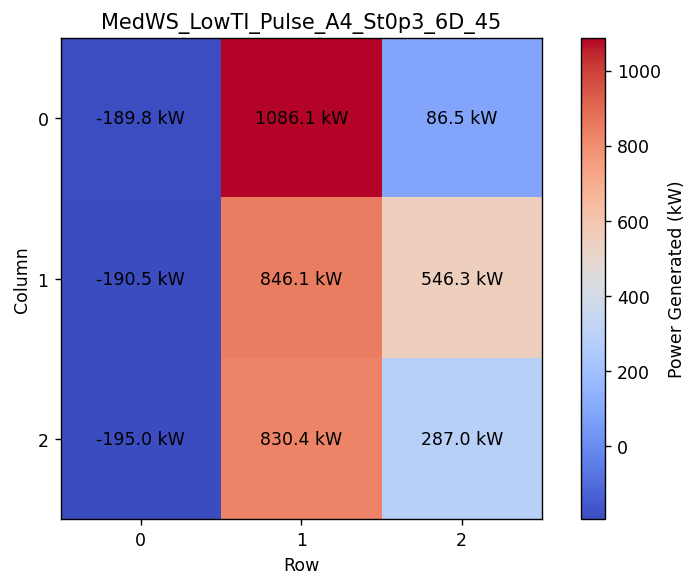

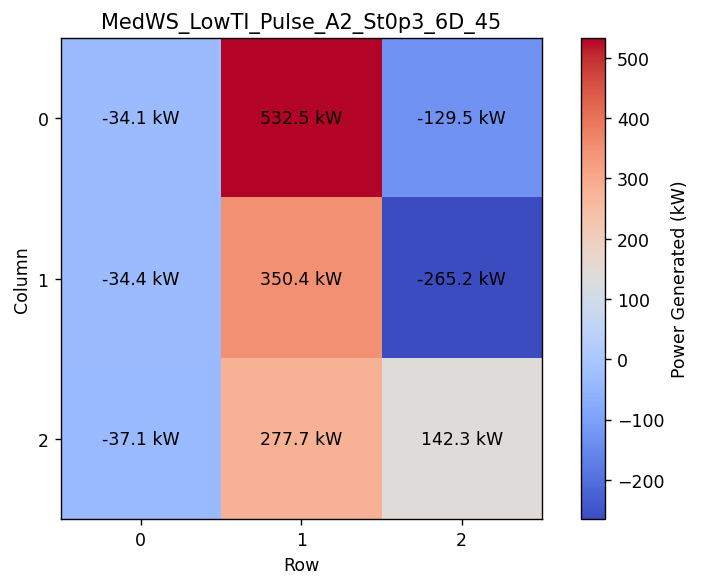

In [108]:
# Create the heatmap
for caseiter , case in enumerate(cases):
    fig, ax = plt.subplots(figsize=(8,5),dpi=125)

    #col by row
    power_data  = np.zeros((3,3))

    titer = 0
    for row in range(3):
        for col in range(3):
            turbine_name = turbine_names[titer]
            #power_data[col,row] = FLORIS_awc_turbine_data[case][turbine_name]
            power_data[col,row] = LES_turbine_data[case][turbine_name]
            titer += 1
    import matplotlib.colors as mcolors

    #levels = np.linspace(-200,200,121)
    cmap = plt.get_cmap('coolwarm')
    #norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    #cax = ax.imshow(power_data, cmap=cmap, norm=norm, interpolation='nearest')
    cax = ax.imshow(power_data, cmap=cmap, interpolation='nearest')
    # Add text annotations with 1 decimal place and 'kW'
    for i in range(power_data.shape[0]):
        for j in range(power_data.shape[1]):
            ax.text(j, i, f'{power_data[i, j]:.1f} kW', ha='center', va='center', color='k')

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Power Generated (kW)')
    #cticks = np.linspace(levels[0],levels[-1],5)
    #cbar.set_ticks(cticks)

    # Set labels and title
    ax.set_xticks(np.arange(power_data.shape[1]))
    ax.set_yticks(np.arange(power_data.shape[0]))
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
    #ax.set_title('Generated Power by Turbine\n'+windfarm_names[farmiter])
    ax.set_title(case)

MedWS_LowTI_Pulse_A4_St0p3_6D_45
MedWS_LowTI_Pulse_A2_St0p3_6D_45


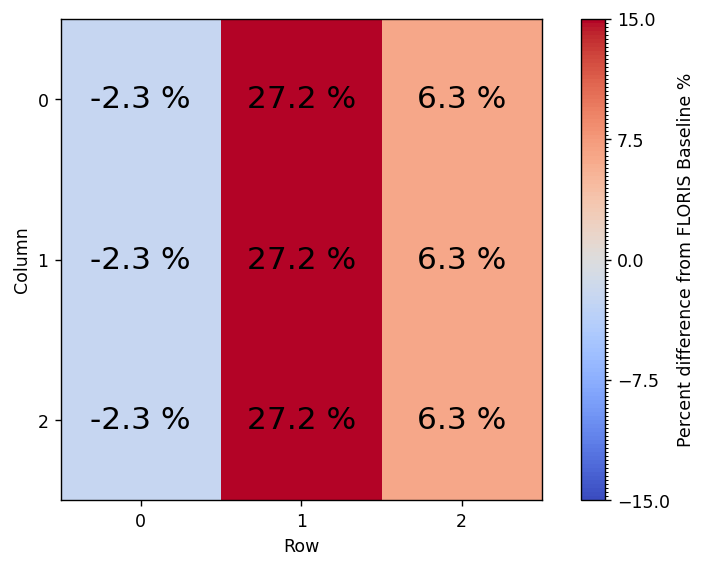

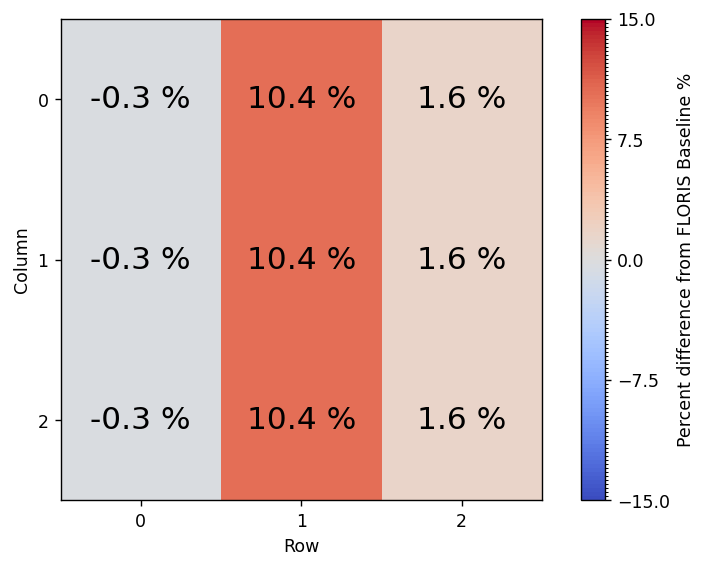

In [109]:
# Create the heatmap
fsize=18
for caseiter , case in enumerate(cases):
    fig, ax = plt.subplots(figsize=(8,5),dpi=125)

    #col by row
    power_data  = np.zeros((3,3))

    titer = 0
    for row in range(3):
        for col in range(3):
            turbine_name = turbine_names[titer]
            #power_data[col,row] = 100*(FLORIS_diff_turbine_data[farm][turbine_name]-LES_turbine_data[farm][turbine_name])/LES_turbine_data[farm][turbine_name]
            #power_data[col,row] = FLORIS_diff_turbine_data[case][turbine_name]
            power_data[col,row] = 100*(FLORIS_awc_turbine_data[case][turbine_name]-FLORIS_baseline_turbine_data[case][turbine_name])/FLORIS_baseline_turbine_data[case][turbine_name]
            titer += 1
    import matplotlib.colors as mcolors

    levels = np.linspace(-15,15,121)
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    cax = ax.imshow(power_data, cmap=cmap, norm=norm, interpolation='nearest')
    #cax = ax.imshow(power_data, cmap=cmap, interpolation='nearest')
    # Add text annotations with 1 decimal place and 'kW'
    for i in range(power_data.shape[0]):
        for j in range(power_data.shape[1]):
            ax.text(j, i, f'{power_data[i, j]:.1f} %', ha='center', va='center', color='k',fontsize=fsize)

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Percent difference from FLORIS Baseline %')
    cticks = np.linspace(levels[0],levels[-1],5)
    cbar.set_ticks(cticks)

    # Set labels and title
    ax.set_xticks(np.arange(power_data.shape[1]))
    ax.set_yticks(np.arange(power_data.shape[0]))
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
    #ax.set_title('Generated Power by Turbine\n'+windfarm_names[farmiter])
    #ax.set_title(case)
    print(case)

MedWS_LowTI_Pulse_A4_St0p3_6D_45
MedWS_LowTI_Pulse_A2_St0p3_6D_45


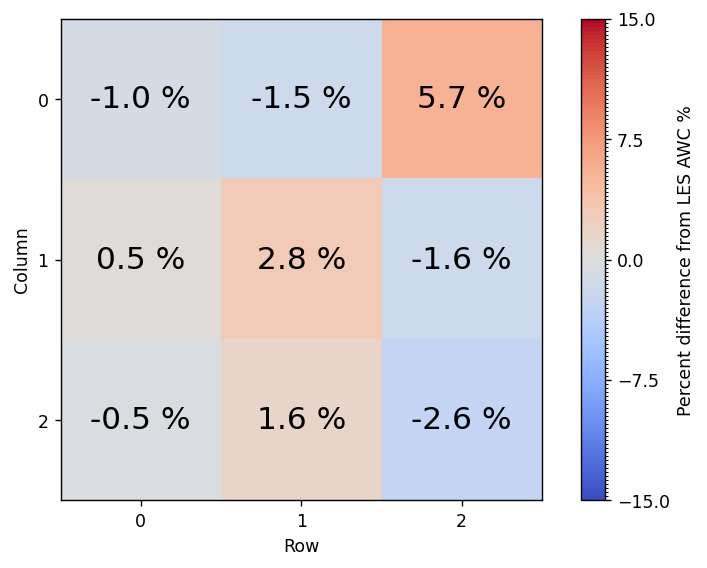

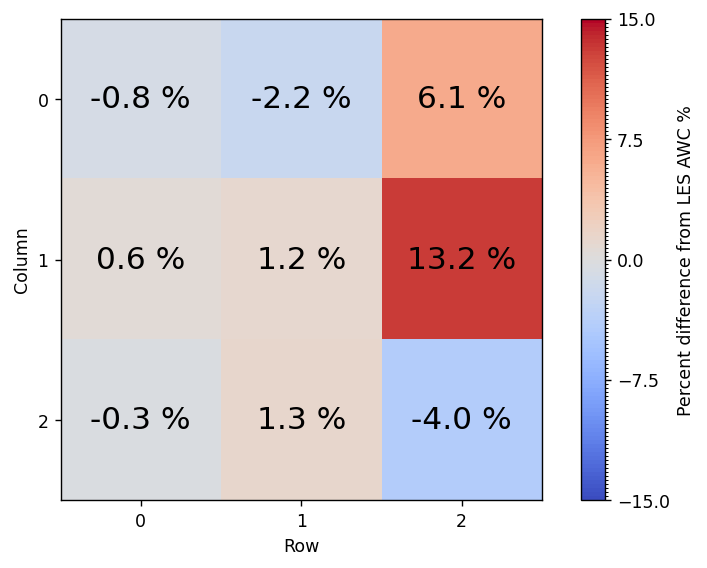

In [110]:
# Create the heatmap
fsize=18
for caseiter , case in enumerate(cases):
    fig, ax = plt.subplots(figsize=(8,5),dpi=125)

    #col by row
    power_data  = np.zeros((3,3))

    titer = 0
    for row in range(3):
        for col in range(3):
            turbine_name = turbine_names[titer]
            #power_data[col,row] = 100*(FLORIS_diff_turbine_data[farm][turbine_name]-LES_turbine_data[farm][turbine_name])/LES_turbine_data[farm][turbine_name]
            #power_data[col,row] = FLORIS_diff_turbine_data[case][turbine_name]
            power_data[col,row] = 100*(FLORIS_awc_turbine_data[case][turbine_name]-LES_awc_turbine_data[case][turbine_name])/LES_awc_turbine_data[case][turbine_name]
            titer += 1
    import matplotlib.colors as mcolors

    levels = np.linspace(-15,15,121)
    cmap = plt.get_cmap('coolwarm')
    norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=cmap.N, clip=True)
    cax = ax.imshow(power_data, cmap=cmap, norm=norm, interpolation='nearest')
    #cax = ax.imshow(power_data, cmap=cmap, interpolation='nearest')
    # Add text annotations with 1 decimal place and 'kW'
    for i in range(power_data.shape[0]):
        for j in range(power_data.shape[1]):
            ax.text(j, i, f'{power_data[i, j]:.1f} %', ha='center', va='center', color='k',fontsize=fsize)

    # Add a colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label('Percent difference from LES AWC %')
    cticks = np.linspace(levels[0],levels[-1],5)
    cbar.set_ticks(cticks)

    # Set labels and title
    ax.set_xticks(np.arange(power_data.shape[1]))
    ax.set_yticks(np.arange(power_data.shape[0]))
    ax.set_xlabel('Row')
    ax.set_ylabel('Column')
    #ax.set_title('Generated Power by Turbine\n'+windfarm_names[farmiter])
    #ax.set_title(case)
    print(case)